# **Rose Hearts: AI Powered Breast Cancer Detection System using Mammogram Images with Explainable AI**

## 1. Project Setup and Initialization

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# get data from google drive
!gdown --id 1g6XCfND7B8XLGIdVG8yKca5lq3dxeIlx

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1g6XCfND7B8XLGIdVG8yKca5lq3dxeIlx
From (redirected): https://drive.google.com/uc?id=1g6XCfND7B8XLGIdVG8yKca5lq3dxeIlx&confirm=t&uuid=0f258e3b-5391-4834-a5d0-841a793a46ca
To: /content/Mammogram_Dataset_CLAHE.zip
100% 621M/621M [00:09<00:00, 65.7MB/s]


In [ ]:
# unzip the folder
!unzip /content/Mammogram_Dataset_CLAHE.zip

Streaming output truncated to the last 5000 lines.
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7322.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7323.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7324.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7325.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7326.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7327.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7328.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7329.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant733.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7330.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7331.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7332.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7333.png  
  inflating: Mammogram_Dataset_CLAHE/malignant/malignant7334.png  
  inflating:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import shutil
import random
import glob
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB0, ResNet50, InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
!pip install imbalanced-learn
!pip install lime
from imblearn.over_sampling import SMOTE
import lime
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=653f081d95ec0ad86784a68c73a9fd8c3599288a08e406ad0abe75af1a044033
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
# Global Constants

# --- Configuration ---
SEED = 42
BATCH_SIZE = 32
INITIAL_EPOCHS = 7
FINE_TUNE_EPOCHS = 4
INIT_LR = 1e-3
FT_LR = 1e-5

# Model Input Sizes (This is CRITICAL!)
RESNET_SIZE = (224, 224)
EFFICIENTNET_SIZE = (224, 224)
INCEPTION_SIZE = (299, 299)

# 3 classes
CLASSES = ['benign', 'malignant', 'normal']

## 2. Data Exploration and Verification (EDA)

In [ ]:
# 1. Get all file paths and labels
data_dir = "/content/Mammogram_Dataset_CLAHE"
filepaths = []
labels = []

# Get all file paths and labels
for cls in CLASSES:
    class_path = os.path.join(data_dir, cls)
    # Check if the path is a directory and not a file (like .DS_Store or our new 'train' folder)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            filepaths.append(os.path.join(class_path, img_name))
            labels.append(cls)

# Create a DataFrame for easier handling
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

Total images found: 26602


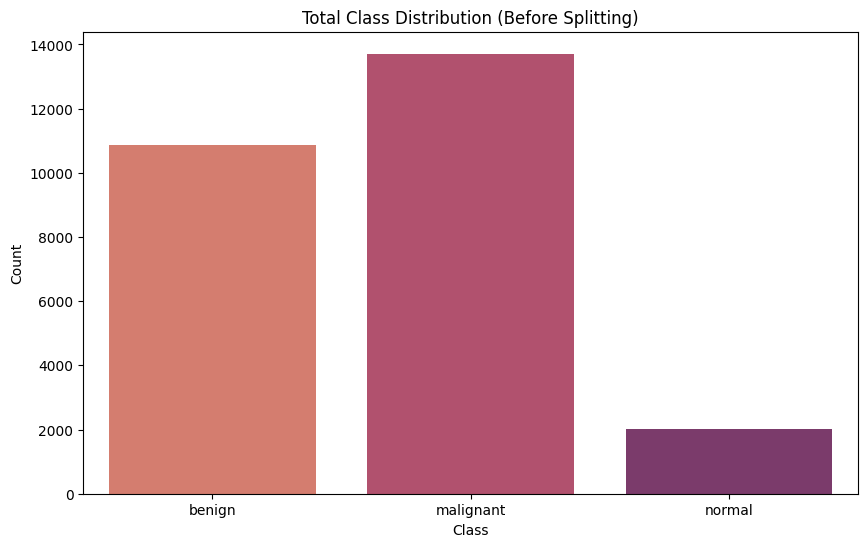

In [ ]:
# 2. Visualize Class Distribution (This is the original EDA plot)
print(f"Total images found: {len(df)}")
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, order=CLASSES, palette='flare')
plt.title('Total Class Distribution (Before Splitting)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
# 3. Data Splitting
# Create Train, Validation, and Test Splits (60% Train, 20% Val, 20% Test)

# Define directory paths
ROOT_DIR = "/content/Mammogram_Dataset_CLAHE" # Already defined, but defined for clarity
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
VAL_DIR = os.path.join(ROOT_DIR, 'val')
TEST_DIR = os.path.join(ROOT_DIR, 'test')

# Define split percentages
TRAIN_SPLIT = 0.6  # 60% for training
VAL_SPLIT = 0.2    # 20% for validation
# TEST_SPLIT = 0.2   (Implicitly the remainder)

print("\nSplitting files into train, val, and test directories...")

# Clean up old directories if they exist
for directory in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

# Create subdirectories for each class
for cls in CLASSES:
    os.makedirs(os.path.join(TRAIN_DIR, cls))
    os.makedirs(os.path.join(VAL_DIR, cls))
    os.makedirs(os.path.join(TEST_DIR, cls))


Splitting files into train, val, and test directories...


In [ ]:
# Perform the split and copy files
for cls in CLASSES:
    src_dir = os.path.join(ROOT_DIR, cls)
    # Ensure we only process files, not the new directories
    all_images = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    random.shuffle(all_images)

    # Calculate split indices
    train_count = int(len(all_images) * TRAIN_SPLIT)
    val_count = int(len(all_images) * VAL_SPLIT)

    train_images = all_images[:train_count]
    val_images = all_images[train_count : train_count + val_count]
    test_images = all_images[train_count + val_count:]

    # Copy files to new directories
    for img_name in train_images:
        shutil.copy(os.path.join(src_dir, img_name), os.path.join(TRAIN_DIR, cls, img_name))
    for img_name in val_images:
        shutil.copy(os.path.join(src_dir, img_name), os.path.join(VAL_DIR, cls, img_name))
    for img_name in test_images:
        shutil.copy(os.path.join(src_dir, img_name), os.path.join(TEST_DIR, cls, img_name))

print("File splitting complete.")

File splitting complete.


In [ ]:
# 4. Verification (Check counts and sample images)

print("\nTraining Set Distribution:")
for cls in CLASSES:
    print(f"  {cls}: {len(os.listdir(os.path.join(TRAIN_DIR, cls)))}")

print("\nValidation Set Distribution:")
for cls in CLASSES:
    print(f"  {cls}: {len(os.listdir(os.path.join(VAL_DIR, cls)))}")

print("\nTest Set Distribution:")
for cls in CLASSES:
    print(f"  {cls}: {len(os.listdir(os.path.join(TEST_DIR, cls)))}")


Training Set Distribution:
  benign: 6519
  malignant: 8226
  normal: 1215

Validation Set Distribution:
  benign: 2173
  malignant: 2742
  normal: 405

Test Set Distribution:
  benign: 2174
  malignant: 2742
  normal: 406



Sample Images from Training Set


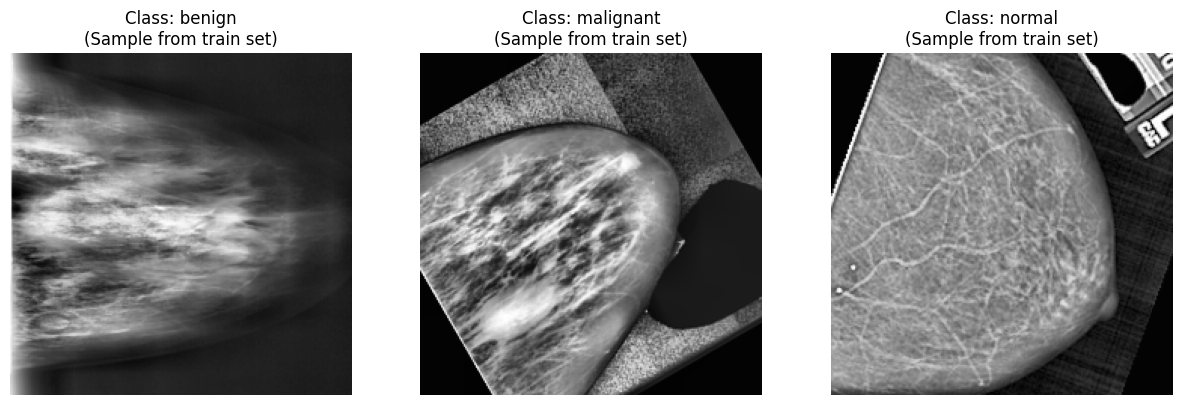

In [ ]:
# Function to show sample images from the new directories
def show_sample_images_from_dirs(base_dir):
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(CLASSES):
        # Find one sample image from the training directory for this class
        class_dir = os.path.join(base_dir, cls)
        sample_img_name = os.listdir(class_dir)[3] # Get a random image
        sample_path = os.path.join(class_dir, sample_img_name)

        img = load_img(sample_path)
        plt.subplot(1, len(CLASSES), i+1)
        plt.title(f"Class: {cls}\n(Sample from {os.path.basename(base_dir)} set)")
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

print("\nSample Images from Training Set")
show_sample_images_from_dirs(TRAIN_DIR)

## 3. Data Preparation (Generators & Class Weights)

In [ ]:
from tensorflow.keras.applications import resnet50, inception_v3, efficientnet
from sklearn.utils.class_weight import compute_class_weight

# 1. Calculate Class Weights
# We base this on the *training data* to inform the model
print("Calculating class weights...")

# Create a list of all training sample labels (as integers)
# We use the order: 0='benign', 1='malignant', 2='normal'
train_labels_list = []
for cls_index, cls_name in enumerate(CLASSES):
    num_samples = len(os.listdir(os.path.join(TRAIN_DIR, cls_name)))
    train_labels_list.extend([cls_index] * num_samples)

# Calculate weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_list),
    y=train_labels_list
)

# Create a dictionary mapping class index to weight
# This dict will be passed to model.fit()
class_weights_dict = {i : class_weights[i] for i in range(len(CLASSES))}

print(f"Class indices: {list(enumerate(CLASSES))}")
print(f"Calculated Class Weights: {class_weights_dict}")
print("The model will pay more attention to the minority class ('normal') to reduce false negatives.")

Calculating class weights...
Class indices: [(0, 'benign'), (1, 'malignant'), (2, 'normal')]
Calculated Class Weights: {0: np.float64(0.8160760852891548), 1: np.float64(0.6467298808655483), 2: np.float64(4.378600823045267)}
The model will pay more attention to the minority class ('normal') to reduce false negatives.


In [ ]:
# 2. Create Data Generators
# ---
# NOTE: We only apply augmentations. We do NOT apply any
# 'rescale' or 'preprocessing_function' here.
# This will be done *inside the model* to keep the data pipeline generic.
# ---

# Training generator WITH augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Validation and Test generators WITHOUT augmentation
val_test_datagen = ImageDataGenerator()

In [ ]:
print("\n--- Creating ResNet-50 Generators (224x224) ---")
train_generator_resnet = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=RESNET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED)

validation_generator_resnet = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=RESNET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False) # MUST be False for evaluation

test_generator_resnet = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=RESNET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False) # MUST be False for evaluation


--- Creating ResNet-50 Generators (224x224) ---
Found 15960 images belonging to 3 classes.
Found 5320 images belonging to 3 classes.
Found 5322 images belonging to 3 classes.


In [ ]:
print("\n--- Creating InceptionV3 Generators (299x299) ---")
train_generator_inception = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=INCEPTION_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED)

validation_generator_inception = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=INCEPTION_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False)

test_generator_inception = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=INCEPTION_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False)


--- Creating InceptionV3 Generators (299x299) ---
Found 15960 images belonging to 3 classes.
Found 5320 images belonging to 3 classes.
Found 5322 images belonging to 3 classes.


In [ ]:
print("\n--- Creating EfficientNet-B0 Generators (224x224) ---")
train_generator_effnet = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=EFFICIENTNET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED)

validation_generator_effnet = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=EFFICIENTNET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False)

test_generator_effnet = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=EFFICIENTNET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED,
    shuffle=False)


--- Creating EfficientNet-B0 Generators (224x224) ---
Found 15960 images belonging to 3 classes.
Found 5320 images belonging to 3 classes.
Found 5322 images belonging to 3 classes.


## 4. Model Building (Reusable Function)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import resnet50, inception_v3, efficientnet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

# Define the metrics we care about.
# Precision reduces False Positives
# Recall reduces False Negatives
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc', multi_label=True, num_labels=len(CLASSES)) # Specify for multi-class
]

def build_model(model_name, input_size, metrics):
    """
    Builds a transfer learning model with its specific preprocessing layer.

    Args:
        model_name (str): 'resnet', 'inception', or 'efficientnet'
        input_size (tuple): (height, width)
        metrics (list): List of Keras metrics

    Returns:
        tf.keras.Model: A compiled Keras model
    """

    # 1. Define input layer
    inputs = Input(shape=input_size + (3,), name="input_layer")

    # 2. Add model-specific preprocessing layer and base model
    # The generator feeds [0, 255] images, and this layer normalizes them.
    if model_name == 'resnet':
        # Instantiate base_model without input_tensor, then call it
        base_model = ResNet50(include_top=False, weights='imagenet')
        x = resnet50.preprocess_input(inputs)
        x = base_model(x, training=False) # Call base_model on preprocessed inputs
    elif model_name == 'inception':
        base_model = InceptionV3(include_top=False, weights='imagenet')
        x = inception_v3.preprocess_input(inputs)
        x = base_model(x, training=False)
    elif model_name == 'efficientnet':
        base_model = EfficientNetB0(include_top=False, weights='imagenet')
        x = efficientnet.preprocess_input(inputs)
        x = base_model(x, training=False)

    # Freeze the base model layers initially (they are part of the base_model object)
    base_model.trainable = False

    # 3. Add custom classifier head
    x = GlobalAveragePooling2D(name="global_avg_pool")(x)
    x = Dense(128, activation='relu', name="dense_128")(x)
    x = Dropout(0.5, name="dropout_0.5")(x) # Regularization
    outputs = Dense(len(CLASSES), activation='softmax', name="output_layer")(x)

    # 4. Create and compile
    model = Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
                  loss='categorical_crossentropy',
                  metrics=METRICS)

    print(f"\nSuccessfully built model: {model_name}")
    return model

## 5. Training & Evaluation Helper Functions

In [ ]:
# A dictionary to store the final test results for comparison
all_results = {}

def plot_training_history(history_phase1, history_phase2, model_name):
    """
    Plots the combined training history for two-phase training.
    """
    # Combine history data
    acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
    val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']

    loss = history_phase1.history['loss'] + history_phase2.history['loss']
    val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

    precision = history_phase1.history['precision'] + history_phase2.history['precision']
    val_precision = history_phase1.history['val_precision'] + history_phase2.history['val_precision']

    recall = history_phase1.history['recall'] + history_phase2.history['recall']
    val_recall = history_phase1.history['val_recall'] + history_phase2.history['val_recall']

    total_epochs = len(acc)
    epochs_range = range(total_epochs)
    phase1_epochs = len(history_phase1.history['loss'])

    plt.figure(figsize=(16, 12))
    plt.suptitle(f"Training History: {model_name}", fontsize=16)

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(phase1_epochs - 1, linestyle='--', color='gray', label='Start Fine-Tuning')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(phase1_epochs - 1, linestyle='--', color='gray', label='Start Fine-Tuning')
    plt.legend(loc='upper right')
    plt.title('Loss')

    # Plot Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, precision, label='Training Precision')
    plt.plot(epochs_range, val_precision, label='Validation Precision')
    plt.axvline(phase1_epochs - 1, linestyle='--', color='gray', label='Start Fine-Tuning')
    plt.legend(loc='lower right')
    plt.title('Precision')

    # Plot Recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, recall, label='Training Recall')
    plt.plot(epochs_range, val_recall, label='Validation Recall')
    plt.axvline(phase1_epochs - 1, linestyle='--', color='gray', label='Start Fine-Tuning')
    plt.legend(loc='lower right')
    plt.title('Recall')

    plt.show()

In [ ]:
def evaluate_model(model, test_generator, model_name):
    """
    Evaluates the model on the test set and plots a confusion matrix.
    Returns the test metrics.
    """
    print(f"\n--- Evaluating {model_name} on Test Set ---")

    # 1. Evaluate the model
    test_metrics = model.evaluate(test_generator, verbose=1)

    # Store results
    results = {
        'Loss': test_metrics[0],
        'Accuracy': test_metrics[1],
        'Precision': test_metrics[2],
        'Recall': test_metrics[3],
        'AUC': test_metrics[4]
    }

    print(f"Test Loss:     {results['Loss']:.4f}")
    print(f"Test Accuracy: {results['Accuracy']:.4f}")
    print(f"Test Precision:  {results['Precision']:.4f}")
    print(f"Test Recall:     {results['Recall']:.4f}")
    print(f"Test AUC:        {results['AUC']:.4f}")

    # 2. Get predictions
    # Reset generator to be safe
    test_generator.reset()
    y_pred_probs = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 3. Get true labels
    y_true = test_generator.classes

    # 4. Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))

    # 5. Plot Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return results

## 6. Model 1: ResNet-50 Training & Evaluation

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- 1. Build Model ---
print("\n--- Building ResNet-50 ---")
resnet_model = build_model('resnet', RESNET_SIZE, METRICS)


--- Building ResNet-50 ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Successfully built model: resnet


In [ ]:
# --- 2. Define Callbacks ---
# Checkpoint for initial training
checkpoint_resnet1 = ModelCheckpoint('best_model_resnet_phase1.h5',
                                     monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# Checkpoint for fine-tuning
checkpoint_resnet2 = ModelCheckpoint('best_model_resnet_finetuned.h5',
                                     monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

In [ ]:
# --- 3. Phase 1 Training (Feature Extraction) ---
print("\n--- Phase 1: Training ResNet-50 Classifier Head ---")
history_resnet1 = resnet_model.fit(
    train_generator_resnet,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator_resnet,
    class_weight=class_weights_dict,  # <-- Applying class weights!
    callbacks=[checkpoint_resnet1, early_stopping, reduce_lr]
)


--- Phase 1: Training ResNet-50 Classifier Head ---
Epoch 1/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5870 - auc: 0.7709 - loss: 0.6690 - precision: 0.6024 - recall: 0.5468
Epoch 1: val_loss improved from inf to 0.43245, saving model to best_model_resnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 244s 456ms/step - accuracy: 0.5871 - auc: 0.7710 - loss: 0.6687 - precision: 0.6025 - recall: 0.5470 - val_accuracy: 0.8075 - val_auc: 0.9278 - val_loss: 0.4325 - val_precision: 0.8092 - val_recall: 0.8021 - learning_rate: 0.0010
Epoch 2/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7348 - auc: 0.8871 - loss: 0.3887 - precision: 0.7435 - recall: 0.7226
Epoch 2: val_loss improved from 0.43245 to 0.36889, saving model to best_model_resnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 218s 436ms/step - accuracy: 0.7348 - auc: 0.8872 - loss: 0.3887 - precision: 0.7435 - recall: 0.7226 - val_accuracy: 0.8318 - val_auc: 0.9503 - val_loss: 0.3689 - val_precision: 0.8326 - val_recall: 0.8312 - learning_rate: 0.0010
Epoch 3/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7772 - auc: 0.9131 - loss: 0.3400 - precision: 0.7817 - recall: 0.7677
Epoch 3: val_loss improved from 0.36889 to 0.34047, saving model to best_model_resnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 213s 427ms/step - accuracy: 0.7772 - auc: 0.9131 - loss: 0.3400 - precision: 0.7817 - recall: 0.7677 - val_accuracy: 0.8459 - val_auc: 0.9559 - val_loss: 0.3405 - val_precision: 0.8473 - val_recall: 0.8438 - learning_rate: 0.0010
Epoch 4/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7822 - auc: 0.9215 - loss: 0.3122 - precision: 0.7854 - recall: 0.7774
Epoch 4: val_loss improved from 0.34047 to 0.32239, saving model to best_model_resnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 213s 426ms/step - accuracy: 0.7822 - auc: 0.9215 - loss: 0.3122 - precision: 0.7854 - recall: 0.7774 - val_accuracy: 0.8566 - val_auc: 0.9688 - val_loss: 0.3224 - val_precision: 0.8569 - val_recall: 0.8566 - learning_rate: 0.0010
Epoch 5/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7982 - auc: 0.9277 - loss: 0.3048 - precision: 0.8000 - recall: 0.7922
Epoch 5: val_loss did not improve from 0.32239
499/499 ━━━━━━━━━━━━━━━━━━━━ 213s 427ms/step - accuracy: 0.7982 - auc: 0.9277 - loss: 0.3048 - precision: 0.8000 - recall: 0.7922 - val_accuracy: 0.8605 - val_auc: 0.9639 - val_loss: 0.3262 - val_precision: 0.8605 - val_recall: 0.8603 - learning_rate: 0.0010
Epoch 6/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7932 - auc: 0.9315 - loss: 0.2969 - precision: 0.7961 - recall: 0.7880
Epoch 6: val_loss did not improve from 0.32239

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
499/499 ━━━━━━━━━━━━━━━━━━━━ 212s 

499/499 ━━━━━━━━━━━━━━━━━━━━ 212s 425ms/step - accuracy: 0.8034 - auc: 0.9362 - loss: 0.2824 - precision: 0.8053 - recall: 0.7996 - val_accuracy: 0.8799 - val_auc: 0.9739 - val_loss: 0.2674 - val_precision: 0.8803 - val_recall: 0.8793 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 7.


In [ ]:
# --- 4. Phase 2 Training (Fine-Tuning) ---
print("\n--- Phase 2: Fine-Tuning ResNet-50 ---")
# Load the best weights from phase 1
resnet_model.load_weights('best_model_resnet_phase1.h5')

# Unfreeze the base model
# The base model is now properly encapsulated as a layer named 'resnet50'
resnet_model.get_layer('resnet50').trainable = True

# Re-compile with a very low learning rate
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR), # <-- Low FT learning rate
    loss='categorical_crossentropy',
    metrics=METRICS
)

# Continue training
history_resnet2 = resnet_model.fit(
    train_generator_resnet,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS, # Total epochs
    initial_epoch=history_resnet1.epoch[-1] + 1, # Start from where we left off
    validation_data=validation_generator_resnet,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_resnet2, early_stopping] # Use new checkpoint
)


--- Phase 2: Fine-Tuning ResNet-50 ---
Epoch 8/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.8093 - auc: 0.9342 - loss: 0.4221 - precision: 0.8107 - recall: 0.8072
Epoch 8: val_loss improved from inf to 0.33439, saving model to best_model_resnet_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 361s 589ms/step - accuracy: 0.8092 - auc: 0.9342 - loss: 0.4220 - precision: 0.8107 - recall: 0.8071 - val_accuracy: 0.8462 - val_auc: 0.9570 - val_loss: 0.3344 - val_precision: 0.8464 - val_recall: 0.8453
Epoch 9/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8199 - auc: 0.9434 - loss: 0.2709 - precision: 0.8211 - recall: 0.8178
Epoch 9: val_loss improved from 0.33439 to 0.22585, saving model to best_model_resnet_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 261s 523ms/step - accuracy: 0.8199 - auc: 0.9434 - loss: 0.2709 - precision: 0.8211 - recall: 0.8178 - val_accuracy: 0.8944 - val_auc: 0.9793 - val_loss: 0.2259 - val_precision: 0.8947 - val_recall: 0.8942
Epoch 10/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.8508 - auc: 0.9614 - loss: 0.2217 - precision: 0.8520 - recall: 0.8500
Epoch 10: val_loss improved from 0.22585 to 0.19084, saving model to best_model_resnet_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 264s 529ms/step - accuracy: 0.8508 - auc: 0.9614 - loss: 0.2217 - precision: 0.8520 - recall: 0.8500 - val_accuracy: 0.9122 - val_auc: 0.9851 - val_loss: 0.1908 - val_precision: 0.9122 - val_recall: 0.9120
Epoch 11/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.8764 - auc: 0.9716 - loss: 0.1945 - precision: 0.8774 - recall: 0.8752
Epoch 11: val_loss improved from 0.19084 to 0.17546, saving model to best_model_resnet_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 262s 526ms/step - accuracy: 0.8764 - auc: 0.9716 - loss: 0.1945 - precision: 0.8774 - recall: 0.8752 - val_accuracy: 0.9235 - val_auc: 0.9884 - val_loss: 0.1755 - val_precision: 0.9237 - val_recall: 0.9233
Restoring model weights from the end of the best epoch: 11.


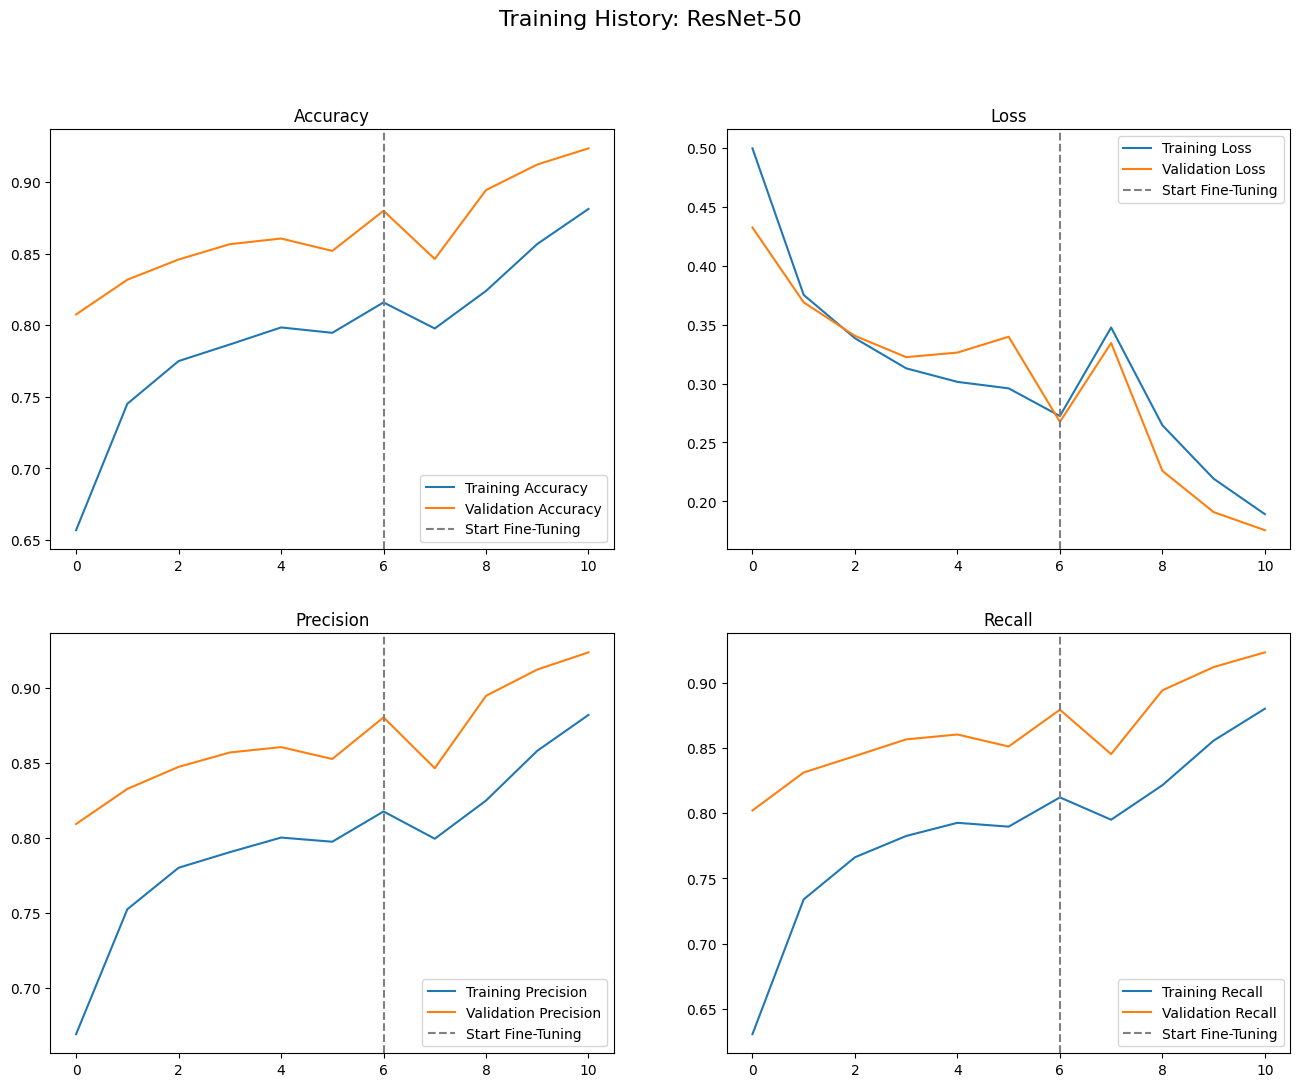

In [ ]:
# --- 5. Plot History ---
plot_training_history(history_resnet1, history_resnet2, "ResNet-50")


--- Evaluating ResNet-50 on Test Set ---
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.8861 - auc: 0.4196 - loss: 0.2637 - precision: 0.8864 - recall: 0.8856
Test Loss:     0.1843
Test Accuracy: 0.9183
Test Precision:  0.9184
Test Recall:     0.9175
Test AUC:        0.9864
167/167 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step

Classification Report:
              precision    recall  f1-score   support

      benign       0.91      0.88      0.90      2174
   malignant       0.91      0.93      0.92      2742
      normal       0.99      1.00      1.00       406

    accuracy                           0.92      5322
   macro avg       0.94      0.94      0.94      5322
weighted avg       0.92      0.92      0.92      5322

Confusion Matrix:


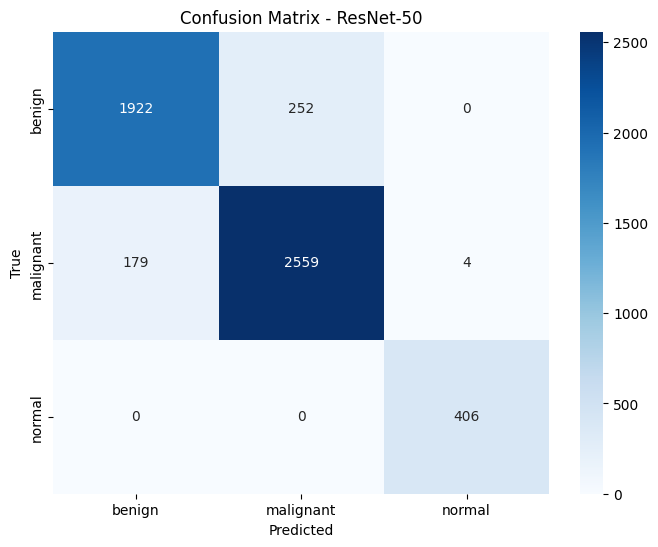

In [ ]:
# --- 6. Final Evaluation ---
# Load the best fine-tuned model
resnet_model.load_weights('best_model_resnet_finetuned.h5')
all_results['ResNet-50'] = evaluate_model(resnet_model, test_generator_resnet, "ResNet-50")

## 7. Model 2: InceptionV3 Training & Evaluation

In [ ]:
# --- 1. Build Model ---
print("\n--- Building InceptionV3 ---")
inception_model = build_model('inception', INCEPTION_SIZE, METRICS)


--- Building InceptionV3 ---
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Successfully built model: inception


In [ ]:
# --- 2. Define Callbacks ---
checkpoint_inception1 = ModelCheckpoint('best_model_inception_phase1.h5',
                                        monitor='val_loss', save_best_only=True, mode='min', verbose=1)
checkpoint_inception2 = ModelCheckpoint('best_model_inception_finetuned.h5',
                                        monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# We can re-use the same 'early_stopping' and 'reduce_lr' callbacks

In [ ]:
# --- 3. Phase 1 Training (Feature Extraction) ---
print("\n--- Phase 1: Training InceptionV3 Classifier Head ---")
history_inception1 = inception_model.fit(
    train_generator_inception,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator_inception,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_inception1, early_stopping, reduce_lr]
)


--- Phase 1: Training InceptionV3 Classifier Head ---
Epoch 1/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.7205 - auc: 0.8908 - loss: 0.7395 - precision: 0.7479 - recall: 0.6769
Epoch 1: val_loss improved from inf to 0.60884, saving model to best_model_inception_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 409s 779ms/step - accuracy: 0.7203 - auc: 0.8907 - loss: 0.7393 - precision: 0.7478 - recall: 0.6767 - val_accuracy: 0.6707 - val_auc: 0.8225 - val_loss: 0.6088 - val_precision: 0.6735 - val_recall: 0.6600 - learning_rate: 0.0010
Epoch 2/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.6204 - auc: 0.7939 - loss: 0.5130 - precision: 0.6298 - recall: 0.5924
Epoch 2: val_loss improved from 0.60884 to 0.56494, saving model to best_model_inception_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 360s 720ms/step - accuracy: 0.6204 - auc: 0.7940 - loss: 0.5130 - precision: 0.6298 - recall: 0.5924 - val_accuracy: 0.7092 - val_auc: 0.8528 - val_loss: 0.5649 - val_precision: 0.7109 - val_recall: 0.7021 - learning_rate: 0.0010
Epoch 3/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6481 - auc: 0.8154 - loss: 0.4915 - precision: 0.6550 - recall: 0.6227
Epoch 3: val_loss improved from 0.56494 to 0.56102, saving model to best_model_inception_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 356s 714ms/step - accuracy: 0.6481 - auc: 0.8154 - loss: 0.4915 - precision: 0.6550 - recall: 0.6226 - val_accuracy: 0.6966 - val_auc: 0.8608 - val_loss: 0.5610 - val_precision: 0.6994 - val_recall: 0.6919 - learning_rate: 0.0010
Epoch 4/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.6463 - auc: 0.8187 - loss: 0.4782 - precision: 0.6559 - recall: 0.6282
Epoch 4: val_loss did not improve from 0.56102
499/499 ━━━━━━━━━━━━━━━━━━━━ 361s 724ms/step - accuracy: 0.6463 - auc: 0.8187 - loss: 0.4782 - precision: 0.6559 - recall: 0.6282 - val_accuracy: 0.6742 - val_auc: 0.8688 - val_loss: 0.5718 - val_precision: 0.6754 - val_recall: 0.6720 - learning_rate: 0.0010
Epoch 5/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.6574 - auc: 0.8304 - loss: 0.4643 - precision: 0.6672 - recall: 0.6398
Epoch 5: val_loss improved from 0.56102 to 0.55019, saving model to best_model_inception_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 365s 732ms/step - accuracy: 0.6573 - auc: 0.8304 - loss: 0.4643 - precision: 0.6672 - recall: 0.6398 - val_accuracy: 0.7299 - val_auc: 0.8671 - val_loss: 0.5502 - val_precision: 0.7336 - val_recall: 0.7209 - learning_rate: 0.0010
Epoch 6/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.6700 - auc: 0.8405 - loss: 0.4612 - precision: 0.6781 - recall: 0.6460
Epoch 6: val_loss improved from 0.55019 to 0.53529, saving model to best_model_inception_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 364s 730ms/step - accuracy: 0.6700 - auc: 0.8405 - loss: 0.4612 - precision: 0.6781 - recall: 0.6460 - val_accuracy: 0.7291 - val_auc: 0.8803 - val_loss: 0.5353 - val_precision: 0.7322 - val_recall: 0.7258 - learning_rate: 0.0010
Epoch 7/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.6819 - auc: 0.8531 - loss: 0.4344 - precision: 0.6871 - recall: 0.6659
Epoch 7: val_loss improved from 0.53529 to 0.48377, saving model to best_model_inception_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 364s 730ms/step - accuracy: 0.6819 - auc: 0.8531 - loss: 0.4344 - precision: 0.6871 - recall: 0.6660 - val_accuracy: 0.7500 - val_auc: 0.8941 - val_loss: 0.4838 - val_precision: 0.7499 - val_recall: 0.7483 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 7.


In [ ]:
# --- 4. Phase 2 Training (Fine-Tuning) ---
print("\n--- Phase 2: Fine-Tuning InceptionV3 ---")
inception_model.load_weights('best_model_inception_phase1.h5')
inception_model.get_layer('inception_v3').trainable = True

inception_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history_inception2 = inception_model.fit(
    train_generator_inception,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history_inception1.epoch[-1] + 1,
    validation_data=validation_generator_inception,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_inception2, early_stopping]
)


--- Phase 2: Fine-Tuning InceptionV3 ---
Epoch 8/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.6879 - auc: 0.8426 - loss: 0.6416 - precision: 0.6927 - recall: 0.6781
Epoch 8: val_loss improved from inf to 0.47378, saving model to best_model_inception_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 591s 1s/step - accuracy: 0.6879 - auc: 0.8426 - loss: 0.6413 - precision: 0.6927 - recall: 0.6781 - val_accuracy: 0.7615 - val_auc: 0.9138 - val_loss: 0.4738 - val_precision: 0.7637 - val_recall: 0.7588
Epoch 9/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.7384 - auc: 0.8922 - loss: 0.3703 - precision: 0.7422 - recall: 0.7290
Epoch 9: val_loss improved from 0.47378 to 0.36034, saving model to best_model_inception_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 445s 892ms/step - accuracy: 0.7384 - auc: 0.8922 - loss: 0.3702 - precision: 0.7422 - recall: 0.7290 - val_accuracy: 0.8374 - val_auc: 0.9491 - val_loss: 0.3603 - val_precision: 0.8394 - val_recall: 0.8352
Epoch 10/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7850 - auc: 0.9230 - loss: 0.3171 - precision: 0.7876 - recall: 0.7812
Epoch 10: val_loss improved from 0.36034 to 0.29756, saving model to best_model_inception_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 438s 878ms/step - accuracy: 0.7850 - auc: 0.9230 - loss: 0.3171 - precision: 0.7876 - recall: 0.7813 - val_accuracy: 0.8703 - val_auc: 0.9648 - val_loss: 0.2976 - val_precision: 0.8707 - val_recall: 0.8682
Epoch 11/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.8231 - auc: 0.9439 - loss: 0.2706 - precision: 0.8244 - recall: 0.8207
Epoch 11: val_loss improved from 0.29756 to 0.23916, saving model to best_model_inception_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 437s 876ms/step - accuracy: 0.8231 - auc: 0.9439 - loss: 0.2706 - precision: 0.8244 - recall: 0.8207 - val_accuracy: 0.8985 - val_auc: 0.9802 - val_loss: 0.2392 - val_precision: 0.8991 - val_recall: 0.8979
Restoring model weights from the end of the best epoch: 11.


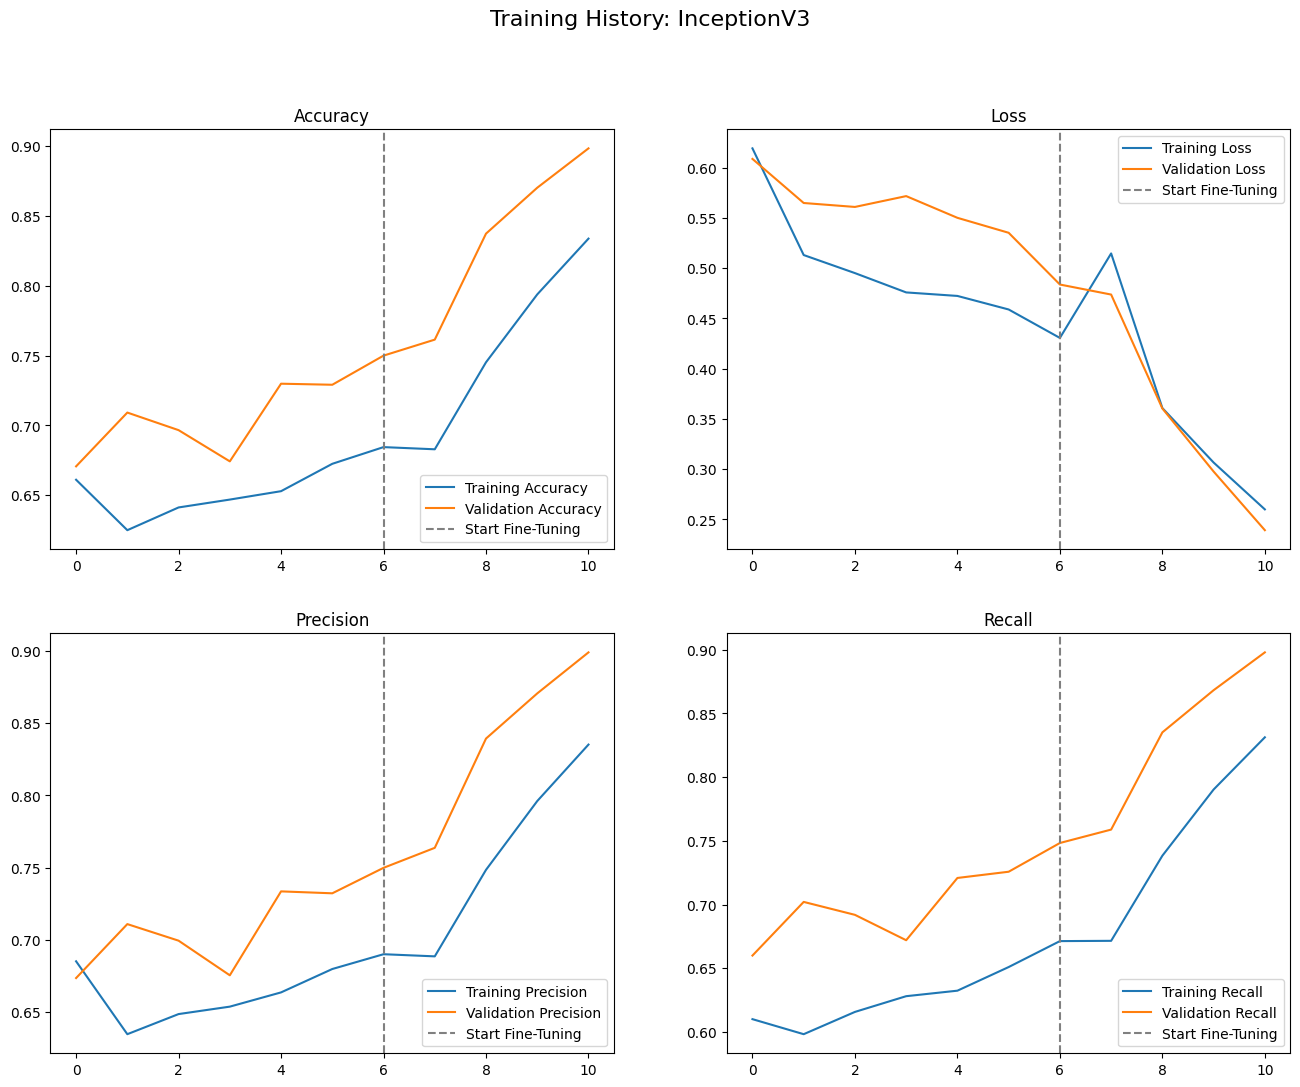

In [ ]:
# --- 5. Plot History ---
plot_training_history(history_inception1, history_inception2, "InceptionV3")


--- Evaluating InceptionV3 on Test Set ---
167/167 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - accuracy: 0.8211 - auc: 0.4120 - loss: 0.3973 - precision: 0.8216 - recall: 0.8203
Test Loss:     0.2493
Test Accuracy: 0.8893
Test Precision:  0.8899
Test Recall:     0.8888
Test AUC:        0.9776
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step

Classification Report:
              precision    recall  f1-score   support

      benign       0.90      0.83      0.86      2174
   malignant       0.87      0.92      0.90      2742
      normal       0.97      1.00      0.98       406

    accuracy                           0.89      5322
   macro avg       0.91      0.92      0.91      5322
weighted avg       0.89      0.89      0.89      5322

Confusion Matrix:


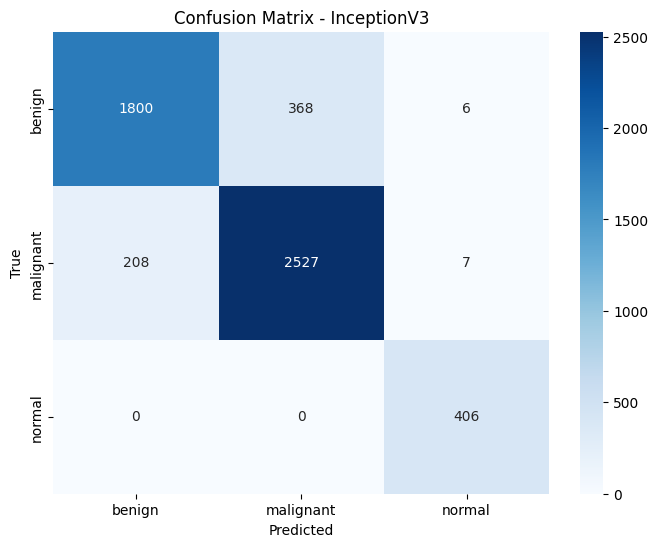

In [ ]:
# --- 6. Final Evaluation ---
inception_model.load_weights('best_model_inception_finetuned.h5')
all_results['InceptionV3'] = evaluate_model(inception_model, test_generator_inception, "InceptionV3")

## 8. Model 3: EfficientNet-B0 Training & Evaluation

In [ ]:
# --- 1. Build Model ---
print("\n--- Building EfficientNet-B0 ---")
effnet_model = build_model('efficientnet', EFFICIENTNET_SIZE, METRICS)


--- Building EfficientNet-B0 ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Successfully built model: efficientnet


In [ ]:
# --- 2. Define Callbacks ---
# We define new checkpoints for this model
checkpoint_effnet1 = ModelCheckpoint('best_model_effnet_phase1.h5',
                                     monitor='val_loss', save_best_only=True, mode='min', verbose=1)
checkpoint_effnet2 = ModelCheckpoint('best_model_effnet_finetuned.h5',
                                     monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# We can re-use the same 'early_stopping' and 'reduce_lr' callbacks from Section 6

In [ ]:
# --- 3. Phase 1 Training (Feature Extraction) ---
print("\n--- Phase 1: Training EfficientNet-B0 Classifier Head ---")
history_effnet1 = effnet_model.fit(
    train_generator_effnet,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator_effnet,
    class_weight=class_weights_dict,  # <-- Applying class weights!
    callbacks=[checkpoint_effnet1, early_stopping, reduce_lr]
)


--- Phase 1: Training EfficientNet-B0 Classifier Head ---
Epoch 1/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.7742 - auc: 0.9152 - loss: 0.5677 - precision: 0.7878 - recall: 0.7516
Epoch 1: val_loss improved from inf to 0.36758, saving model to best_model_effnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 255s 456ms/step - accuracy: 0.7742 - auc: 0.9152 - loss: 0.5675 - precision: 0.7878 - recall: 0.7515 - val_accuracy: 0.8466 - val_auc: 0.9538 - val_loss: 0.3676 - val_precision: 0.8475 - val_recall: 0.8459 - learning_rate: 0.0010
Epoch 2/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7962 - auc: 0.9235 - loss: 0.3194 - precision: 0.7991 - recall: 0.7936
Epoch 2: val_loss improved from 0.36758 to 0.33678, saving model to best_model_effnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 200s 400ms/step - accuracy: 0.7962 - auc: 0.9235 - loss: 0.3194 - precision: 0.7991 - recall: 0.7936 - val_accuracy: 0.8538 - val_auc: 0.9541 - val_loss: 0.3368 - val_precision: 0.8551 - val_recall: 0.8528 - learning_rate: 0.0010
Epoch 3/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8117 - auc: 0.9330 - loss: 0.3021 - precision: 0.8131 - recall: 0.8088
Epoch 3: val_loss improved from 0.33678 to 0.29765, saving model to best_model_effnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 198s 398ms/step - accuracy: 0.8117 - auc: 0.9330 - loss: 0.3020 - precision: 0.8131 - recall: 0.8088 - val_accuracy: 0.8739 - val_auc: 0.9657 - val_loss: 0.2976 - val_precision: 0.8748 - val_recall: 0.8735 - learning_rate: 0.0010
Epoch 4/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8343 - auc: 0.9479 - loss: 0.2684 - precision: 0.8366 - recall: 0.8322
Epoch 4: val_loss improved from 0.29765 to 0.28348, saving model to best_model_effnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 199s 398ms/step - accuracy: 0.8343 - auc: 0.9479 - loss: 0.2684 - precision: 0.8366 - recall: 0.8322 - val_accuracy: 0.8776 - val_auc: 0.9730 - val_loss: 0.2835 - val_precision: 0.8782 - val_recall: 0.8771 - learning_rate: 0.0010
Epoch 5/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8425 - auc: 0.9513 - loss: 0.2547 - precision: 0.8440 - recall: 0.8413
Epoch 5: val_loss improved from 0.28348 to 0.26578, saving model to best_model_effnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 197s 396ms/step - accuracy: 0.8425 - auc: 0.9513 - loss: 0.2547 - precision: 0.8440 - recall: 0.8413 - val_accuracy: 0.8893 - val_auc: 0.9749 - val_loss: 0.2658 - val_precision: 0.8900 - val_recall: 0.8883 - learning_rate: 0.0010
Epoch 6/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8526 - auc: 0.9573 - loss: 0.2413 - precision: 0.8550 - recall: 0.8507
Epoch 6: val_loss improved from 0.26578 to 0.24820, saving model to best_model_effnet_phase1.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 197s 394ms/step - accuracy: 0.8526 - auc: 0.9573 - loss: 0.2413 - precision: 0.8550 - recall: 0.8507 - val_accuracy: 0.9092 - val_auc: 0.9783 - val_loss: 0.2482 - val_precision: 0.9101 - val_recall: 0.9079 - learning_rate: 0.0010
Epoch 7/7
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8535 - auc: 0.9599 - loss: 0.2354 - precision: 0.8555 - recall: 0.8513
Epoch 7: val_loss did not improve from 0.24820
499/499 ━━━━━━━━━━━━━━━━━━━━ 198s 398ms/step - accuracy: 0.8535 - auc: 0.9599 - loss: 0.2354 - precision: 0.8555 - recall: 0.8513 - val_accuracy: 0.8953 - val_auc: 0.9806 - val_loss: 0.2536 - val_precision: 0.8970 - val_recall: 0.8934 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 6.


In [ ]:
# --- 4. Phase 2 Training (Fine-Tuning) ---
print("\n--- Phase 2: Fine-Tuning EfficientNet-B0 ---")
# Load the best weights from phase 1
effnet_model.load_weights('best_model_effnet_phase1.h5')

# Unfreeze the base model
# Note: The base model layer name is 'efficientnetb0'
effnet_model.get_layer('efficientnetb0').trainable = True

# Re-compile with a very low learning rate
effnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR), # <-- Low FT learning rate
    loss='categorical_crossentropy',
    metrics=METRICS
)

# Continue training
history_effnet2 = effnet_model.fit(
    train_generator_effnet,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS, # Total epochs
    initial_epoch=history_effnet1.epoch[-1] + 1, # Start from where we left off
    validation_data=validation_generator_effnet,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_effnet2, early_stopping] # Use new checkpoint
)


--- Phase 2: Fine-Tuning EfficientNet-B0 ---
Epoch 8/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7524 - auc: 0.8939 - loss: 0.8370 - precision: 0.7585 - recall: 0.7436
Epoch 8: val_loss improved from inf to 1.16452, saving model to best_model_effnet_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 347s 542ms/step - accuracy: 0.7523 - auc: 0.8938 - loss: 0.8367 - precision: 0.7585 - recall: 0.7435 - val_accuracy: 0.6117 - val_auc: 0.8592 - val_loss: 1.1645 - val_precision: 0.6220 - val_recall: 0.5942
Epoch 9/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7169 - auc: 0.8737 - loss: 0.4911 - precision: 0.7211 - recall: 0.7082
Epoch 9: val_loss improved from 1.16452 to 0.50124, saving model to best_model_effnet_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 218s 436ms/step - accuracy: 0.7169 - auc: 0.8737 - loss: 0.4910 - precision: 0.7211 - recall: 0.7082 - val_accuracy: 0.8231 - val_auc: 0.9438 - val_loss: 0.5012 - val_precision: 0.8277 - val_recall: 0.8169
Epoch 10/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7620 - auc: 0.9009 - loss: 0.3932 - precision: 0.7656 - recall: 0.7573
Epoch 10: val_loss improved from 0.50124 to 0.39639, saving model to best_model_effnet_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 218s 438ms/step - accuracy: 0.7620 - auc: 0.9009 - loss: 0.3932 - precision: 0.7657 - recall: 0.7574 - val_accuracy: 0.8590 - val_auc: 0.9605 - val_loss: 0.3964 - val_precision: 0.8609 - val_recall: 0.8564
Epoch 11/11
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7944 - auc: 0.9243 - loss: 0.3314 - precision: 0.7975 - recall: 0.7904
Epoch 11: val_loss improved from 0.39639 to 0.30833, saving model to best_model_effnet_finetuned.h5


499/499 ━━━━━━━━━━━━━━━━━━━━ 219s 438ms/step - accuracy: 0.7944 - auc: 0.9243 - loss: 0.3313 - precision: 0.7975 - recall: 0.7904 - val_accuracy: 0.8769 - val_auc: 0.9692 - val_loss: 0.3083 - val_precision: 0.8789 - val_recall: 0.8735
Restoring model weights from the end of the best epoch: 11.


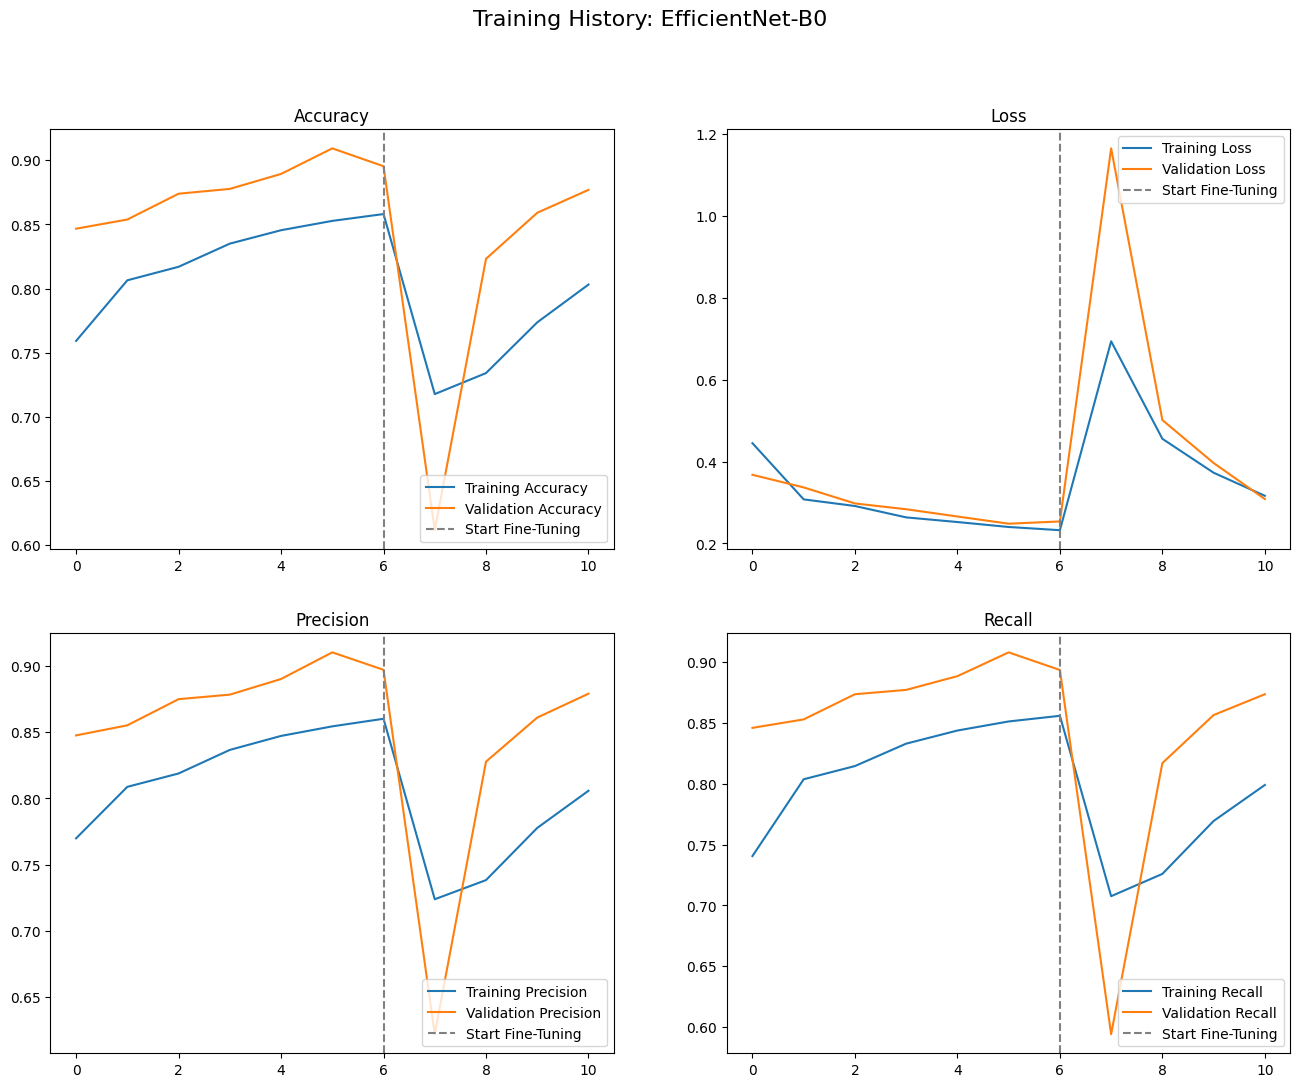

In [ ]:
# --- 5. Plot History ---
plot_training_history(history_effnet1, history_effnet2, "EfficientNet-B0")


--- FINAL EFFICIENTNET-B0 TEST RESULTS ---

--- Evaluating EfficientNet-B0 on Test Set ---
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.8389 - auc: 0.4030 - loss: 0.3938 - precision: 0.8413 - recall: 0.8360
Test Loss:     0.3221
Test Accuracy: 0.8711
Test Precision:  0.8738
Test Recall:     0.8690
Test AUC:        0.9667
167/167 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step

Classification Report:
              precision    recall  f1-score   support

      benign       0.84      0.86      0.85      2174
   malignant       0.89      0.86      0.88      2742
      normal       0.91      1.00      0.95       406

    accuracy                           0.87      5322
   macro avg       0.88      0.91      0.89      5322
weighted avg       0.87      0.87      0.87      5322

Confusion Matrix:


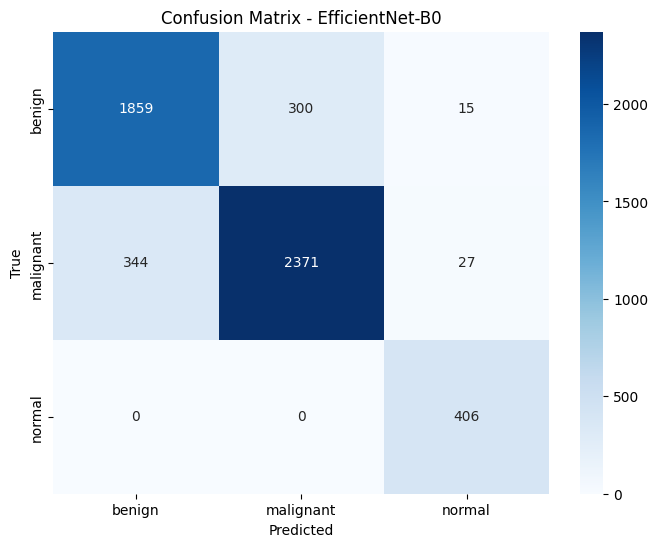

In [ ]:
# --- 6. Final Evaluation (This shows the test results) ---
print("\n--- FINAL EFFICIENTNET-B0 TEST RESULTS ---")
# Load the best fine-tuned model
effnet_model.load_weights('best_model_effnet_finetuned.h5')
# This helper function shows all test results
all_results['EfficientNet-B0'] = evaluate_model(effnet_model, test_generator_effnet, "EfficientNet-B0")

## 9. Comparative Analysis & Model Selection

In [ ]:
print("\n--- Final Model Comparison ---")

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame.from_dict(all_results, orient='index')

# Re-order columns for clarity
results_df = results_df[['Accuracy', 'Precision', 'Recall', 'AUC', 'Loss']]

# Display the comparison table
print(results_df.to_markdown(floatfmt=".4f"))


--- Final Model Comparison ---
|                 |   Accuracy |   Precision |   Recall |    AUC |   Loss |
|:----------------|-----------:|------------:|---------:|-------:|-------:|
| ResNet-50       |     0.9183 |      0.9184 |   0.9175 | 0.9864 | 0.1843 |
| InceptionV3     |     0.8893 |      0.8899 |   0.8888 | 0.9776 | 0.2493 |
| EfficientNet-B0 |     0.8711 |      0.8738 |   0.8690 | 0.9667 | 0.3221 |


In [ ]:
# --- Analysis ---
# Find the best model based on a chosen metric, e.g., F1-score or AUC
# We'll also get the per-class metrics from the classification reports for a deeper dive.

print("\n\n--- Detailed Per-Class Analysis ---")
print("This requires manually reviewing the classification reports printed during evaluation.")
print("Your goal is to find the model with the best **Recall** for 'malignant' (reduces False Negatives)")
print("and the best **Precision** for 'malignant' (reduces False Positives).")



--- Detailed Per-Class Analysis ---
This requires manually reviewing the classification reports printed during evaluation.
Your goal is to find the model with the best **Recall** for 'malignant' (reduces False Negatives)
and the best **Precision** for 'malignant' (reduces False Positives).


In [ ]:
# You can programmatically find the best model based on a metric
best_auc_model = results_df['AUC'].idxmax()
best_recall_model = results_df['Recall'].idxmax()

print(f"\nModel with Best Overall AUC:     {best_auc_model}")
print(f"Model with Best Overall Recall:  {best_recall_model}")

# --- Manually select your best model for XAI ---
# Replace this with your choice based on your analysis
# For example, if EfficientNet was best:
# best_model_name = 'EfficientNet-B0'
# best_model = effnet_model
# best_test_generator = test_generator_effnet

# Or if ResNet was best:
best_model_name = 'ResNet-50'
best_model = resnet_model
best_test_generator = test_generator_resnet

print(f"\nSelected '{best_model_name}' as the best model for XAI.")


Model with Best Overall AUC:     ResNet-50
Model with Best Overall Recall:  ResNet-50

Selected 'ResNet-50' as the best model for XAI.


## 10. Explainable AI (XAI) on the Best Model

In [ ]:
import lime
from lime import lime_image
import shap
import cv2 # OpenCV for image manipulation
from tensorflow.keras.models import Model

print(f"--- Starting XAI for {best_model_name} ---")

# --- 1. Select Sample Images for Explanation ---
# We need to get a few sample images and labels from the test set
# We must reset the generator
best_test_generator.reset()
images, labels = next(best_test_generator)

# Let's pick a few images from this batch
# e.g., img_index = 0
img_index = 1
sample_image_raw = images[img_index] # This is a [0, 255] image
sample_label = labels[img_index]
true_class_index = np.argmax(sample_label)
true_class_name = CLASSES[true_class_index]

# The model's prediction
pred_probs = best_model.predict(np.expand_dims(sample_image_raw, axis=0))
pred_class_index = np.argmax(pred_probs[0])
pred_class_name = CLASSES[pred_class_index]

print(f"Explaining image {img_index}:")
print(f"  True Label:     {true_class_name}")
print(f"  Predicted Label: {pred_class_name} (Confidence: {pred_probs[0][pred_class_index]:.2f})")

--- Starting XAI for ResNet-50 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Explaining image 1:
  True Label:     benign
  Predicted Label: benign (Confidence: 0.98)


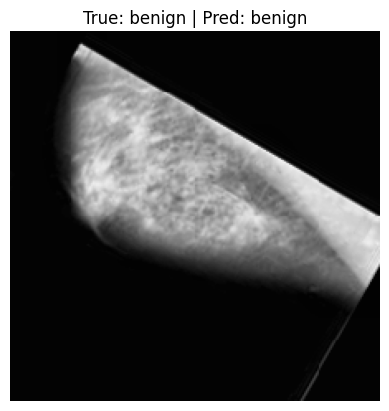

In [ ]:
# We need the image in 0-255 uint8 format for most visualizations
sample_image_viz = sample_image_raw.astype('uint8')

plt.imshow(sample_image_viz)
plt.title(f"True: {true_class_name} | Pred: {pred_class_name}")
plt.axis('off')
plt.show()

In [ ]:
import lime
from lime import lime_image
import shap
import cv2 # OpenCV for image manipulation
from tensorflow.keras.models import Model

print(f"--- Starting XAI for {best_model_name} ---")

# --- 1. Select Sample Images for Explanation ---
# We need to get a few sample images and labels from the test set
# We must reset the generator
best_test_generator.reset()
images, labels = next(best_test_generator)

# Let's pick a few images from this batch
# e.g., img_index = 0
img_index = 1
sample_image_raw = images[img_index] # This is a [0, 255] image
sample_label = labels[img_index]
true_class_index = np.argmax(sample_label)
true_class_name = CLASSES[true_class_index]

# The model's prediction
pred_probs = best_model.predict(np.expand_dims(sample_image_raw, axis=0))
pred_class_index = np.argmax(pred_probs[0])
pred_class_name = CLASSES[pred_class_index]

print(f"Explaining image {img_index}:")
print(f"  True Label:     {true_class_name}")
print(f"  Predicted Label: {pred_class_name} (Confidence: {pred_probs[0][pred_class_index]:.2f})")

# --- 2. XAI Method 1: Grad-CAM ---
# Grad-CAM shows *where* the model is looking.

def get_grad_cam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 1. Access the nested ResNet50 base model
    # Note: Ensure this matches the name in model.summary() usually 'resnet50'
    base_model = model.get_layer('resnet50')

    # 2. Reconstruct the graph to access internal layers
    # We start from the base model's input
    grad_model_input = base_model.input

    # Get the internal conv output (the target for Grad-CAM)
    last_conv_layer_output = base_model.get_layer(last_conv_layer_name).output

    # Get the base model's final output (features)
    x = base_model.output

    # 3. Re-apply the classifier head layers from the original model
    # We reuse the layer instances to keep the trained weights
    x = model.get_layer('global_avg_pool')(x)
    x = model.get_layer('dense_128')(x)
    # We intentionally skip Dropout here to get a deterministic heatmap
    outputs = model.get_layer('output_layer')(x)

    # 4. Create the specialized Grad-CAM model
    # Inputs: Preprocessed image
    # Outputs: [Conv Layer Activations, Final Prediction]
    grad_model = Model(grad_model_input, [last_conv_layer_output, outputs])

    # 5. Compute Gradient
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_grad_cam(img, heatmap, alpha=0.4):
    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_jet = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose heatmap
    superimposed_img = heatmap_jet * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    return superimposed_img

--- Starting XAI for ResNet-50 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Explaining image 1:
  True Label:     benign
  Predicted Label: benign (Confidence: 0.98)


In [ ]:
# --- Find the last convolutional layer ---
# This is tricky and model-specific. You may need to print model.summary()
# EfficientNet: 'top_conv'
# ResNet50: 'conv5_block3_out' (internal name within the resnet50 layer)
# InceptionV3: 'mixed10'

# To see the full layer names inside the base model, uncomment and run the following:
# best_model.get_layer('resnet50').summary()

# Example for EfficientNet-B0:

best_model.summary() # <-- Uncomment to find the layer name

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 128)       │    262,272 │ global_avg_pool[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_0.5         │ (None, 128)       │          0 │ dense_128[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 3)         │        387 │ dropout_0.5[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 71,444,875 (272.54 MB)

 Trainable params: 23,797,251 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,594,504 (181.56 MB)

In [ ]:
last_conv_layer_name = 'conv5_block3_out' # For ResNet50, this is the internal name within the 'resnet50' layer
# if best_model_name == 'ResNet-50':
#    last_conv_layer_name = 'conv5_block3_out'
# elif best_model_name == 'InceptionV3':
#    last_conv_layer_name = 'mixed10'

Generating Grad-CAM for layer: conv5_block3_out


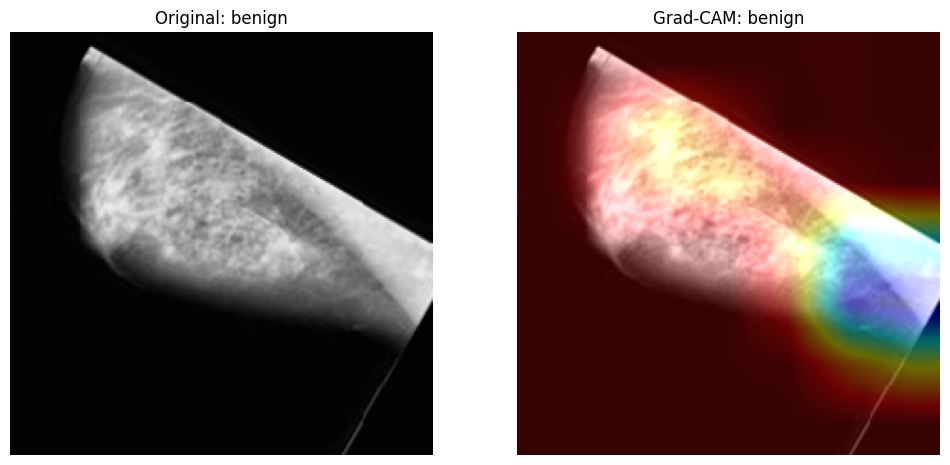

In [ ]:
# # --- Pre-process the image for Grad-CAM (needs model's preprocessor) ---

# We need the specific preprocessor function for ResNet50
from tensorflow.keras.applications import resnet50

# # --- Prepare the image for Grad-CAM ---

# --- 1. Prepare the image ---
# Add batch dimension
raw_img_batch = np.expand_dims(sample_image_raw, axis=0)

# Manually preprocess (ResNet requires specific preprocessing)
# This converts RGB->BGR and centers the pixels
preprocessed_img_batch = resnet50.preprocess_input(raw_img_batch.astype('float32'))

# --- 2. Run Grad-CAM ---
print(f"Generating Grad-CAM for layer: {last_conv_layer_name}")

heatmap = get_grad_cam_heatmap(
    preprocessed_img_batch,
    best_model,
    last_conv_layer_name,
    pred_class_index
)

# --- 3. Visualize ---
gradcam_img = display_grad_cam(sample_image_viz, heatmap)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image_viz)
plt.title(f"Original: {true_class_name}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradcam_img)
plt.title(f"Grad-CAM: {pred_class_name}")
plt.axis('off')
plt.show()

In [ ]:
# # --- 3. XAI Method 2: LIME ---
# # LIME shows which 'superpixels' contribute to a prediction.
# print("\n--- 3. Running LIME ---")
# # LIME needs a function that returns prediction probabilities
# # It also needs images in the [0, 255] range
# def lime_predict_fn(images):
#     # LIME gives images as (num_samples, H, W, 3) with [0, 255]
#     # We must apply the model's preprocessing
#     preprocessed_imgs = preprocessor.predict(images)
#     return best_model.predict(preprocessed_imgs)

# explainer_lime = lime_image.LimeImageExplainer()
# explanation_lime = explainer_lime.explain_instance(
#     sample_image_viz,
#     lime_predict_fn,
#     top_labels=len(CLASSES),
#     hide_color=0,
#     num_samples=1000 # Number of samples to generate
# )

# # Get image and mask for the top predicted class
# temp, mask = explanation_lime.get_image_and_mask(
#     pred_class_index,
#     positive_only=True,
#     num_features=5,
#     hide_rest=False
# )

# plt.imshow(temp.astype('uint8'))
# plt.title(f"LIME: Positive regions for {pred_class_name}")
# plt.axis('off')
# plt.show()


--- 3. Running LIME ---
Explaining instance with LIME (this may take a minute or two)...


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME explanation complete. Generating images...


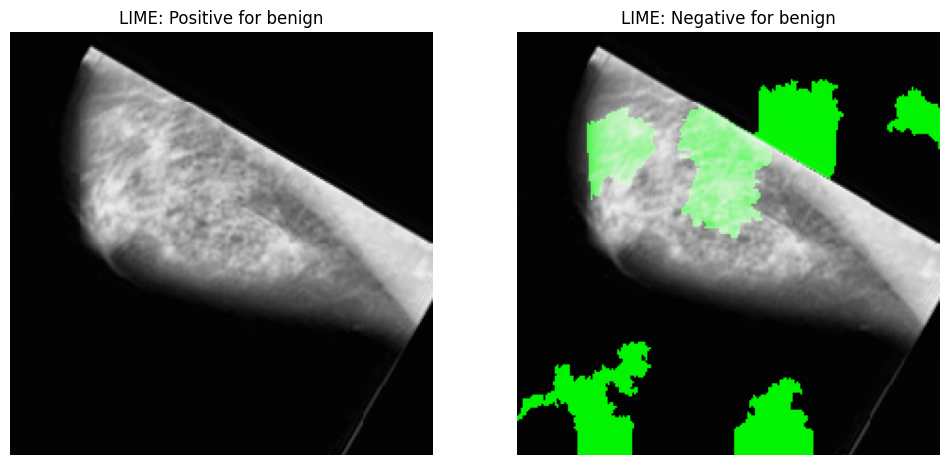

In [ ]:
import lime
from lime import lime_image
from tensorflow.keras.applications import resnet50 # Ensure this is imported

# --- 3. XAI Method 2: LIME ---
# LIME shows which 'superpixels' contribute to a prediction.
print("\n--- 3. Running LIME ---")

# LIME needs a function that returns prediction probabilities (num_samples, num_classes)
# LIME provides images as (num_samples, H, W, 3) with [0, 255] values
def lime_predict_fn(images):
    # 1. LIME gives images as uint8 [0, 255], convert to float32
    images_float = images.astype('float32')

    # 2. Manually apply the *exact same* preprocessing the model was trained with
    preprocessed_imgs = resnet50.preprocess_input(images_float)

    # 3. Get predictions.
    #    Add verbose=0 to prevent flooding the output, as LIME calls this many times.
    return best_model.predict(preprocessed_imgs, verbose=0)

# Initialize the LIME explainer
explainer_lime = lime_image.LimeImageExplainer()

print("Explaining instance with LIME (this may take a minute or two)...")

# Run the explanation
explanation_lime = explainer_lime.explain_instance(
    sample_image_viz,      # The original [0, 255] image for LIME to segment
    lime_predict_fn,       # Our new, correct prediction function
    top_labels=len(CLASSES),
    hide_color=0,
    num_samples=1000       # Number of samples (perturbations) to generate
)

print("LIME explanation complete. Generating images...")

# --- Visualize LIME Results ---

# Get image and mask for the top predicted class (positive evidence)
temp_pos, mask_pos = explanation_lime.get_image_and_mask(
    pred_class_index,
    positive_only=True,
    num_features=5,       # Show the top 5 most positive superpixels
    hide_rest=False       # Show the rest of the image faded
)

# Get image and mask for the top predicted class (negative evidence)
temp_neg, mask_neg = explanation_lime.get_image_and_mask(
    pred_class_index,
    positive_only=False,
    num_features=10,      # Show top 10 most negative superpixels
    hide_rest=False
)

# Plot the results side-by-side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(temp_pos.astype('uint8'))
plt.title(f"LIME: Positive for {pred_class_name}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(temp_neg.astype('uint8'))
plt.title(f"LIME: Negative for {pred_class_name}")
plt.axis('off')

plt.show()

In [ ]:
# # --- 4. XAI Method 3: SHAP ---
# # SHAP assigns an importance value to each pixel.
# # This is VERY computationally expensive.
# print("\n--- 4. Running SHAP ---")

# # SHAP needs a background dataset to "integrate" over
# # We'll take a small, random sample from the training generator
# train_gen_for_shap = train_datagen.flow_from_directory(
#     TRAIN_DIR,
#     target_size=(best_model.input_shape[1], best_model.input_shape[2]),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     seed=SEED
# )
# background_images, _ = next(train_gen_for_shap)
# # Let's use a smaller background set to save time
# background = background_images[np.random.choice(background_images.shape[0], 10, replace=False)]

# # Create the SHAP explainer
# # SHAP works on the preprocessed images
# background_preprocessed = preprocessor.predict(background)
# explainer_shap = shap.DeepExplainer(best_model, background_preprocessed)

# # Preprocess the sample image
# sample_image_preprocessed = preprocessor.predict(np.expand_dims(sample_image_raw, axis=0))

# # Calculate SHAP values
# shap_values = explainer_shap.shap_values(sample_image_preprocessed)

# print("Plotting SHAP values...")
# # Plot the SHAP explanation
# # We use the raw [0, 255] image for visualization
# shap.image_plot(
#     shap_values,
#     np.expand_dims(sample_image_raw.astype(float), axis=0), # Needs float
#     labels=[f"SHAP for {c}" for c in CLASSES]
# )


--- 4. Running SHAP ---
Found 15960 images belonging to 3 classes.
Initializing SHAP DeepExplainer...
Calculating SHAP values (this may take a few minutes)...


Plotting SHAP values...


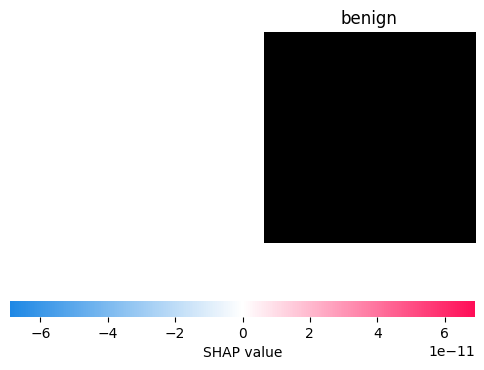

In [ ]:
import shap
import numpy as np
from tensorflow.keras.applications import resnet50

# --- 4. XAI Method 3: SHAP ---
# SHAP assigns an importance value to each pixel.
# This is VERY computationally expensive.
print("\n--- 4. Running SHAP ---")

# 1. Get background data
# SHAP needs a background dataset to "integrate" over
# We'll take a small, random sample from the training directory
train_gen_for_shap = train_datagen.flow_from_directory(
    TRAIN_DIR,
    # Dynamically get the input size from the model
    target_size=(best_model.input_shape[1], best_model.input_shape[2]),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

# Get a single batch of images
background_images_raw, _ = next(train_gen_for_shap)

# Select a small subset (e.g., 10 images) to keep computation time reasonable
# We use these as the "reference" background
background_indices = np.random.choice(background_images_raw.shape[0], 10, replace=False)
background_raw = background_images_raw[background_indices]

# 2. Manually Preprocess the Background
# Convert to float32 and apply ResNet preprocessing (Mean subtraction, BGR conversion)
background_preprocessed = resnet50.preprocess_input(background_raw.astype('float32'))

# 3. Create the SHAP explainer
# We pass the model and the PREPROCESSED background
print("Initializing SHAP DeepExplainer...")
explainer_shap = shap.DeepExplainer(best_model, background_preprocessed)

# 4. Preprocess the Sample Image
# We also need to preprocess the single image we want to explain
sample_image_preprocessed = resnet50.preprocess_input(np.expand_dims(sample_image_raw, axis=0).astype('float32'))

# 5. Calculate SHAP values
print("Calculating SHAP values (this may take a few minutes)...")
# check_additivity=False is REQUIRED for deep models like ResNet to prevent precision errors
shap_values = explainer_shap.shap_values(sample_image_preprocessed, check_additivity=False)

print("Plotting SHAP values...")

# 6. Plot the SHAP explanation
# shap.image_plot expects:
#  - shap_values: The calculated values
#  - pixel_values: The ORIGINAL raw image (0-255) for visualization
shap.image_plot(
    shap_values,
    np.expand_dims(sample_image_raw.astype(float), axis=0),
    labels=CLASSES  # Labels for the columns
)

In [ ]:
import shap
import numpy as np
from tensorflow.keras.applications import resnet50

# --- 4. XAI Method 3: SHAP (using KernelExplainer) ---
# This method is a robust fallback when Deep/Gradient explainers fail.
# It is model-agnostic but VERY SLOW.
print("\n--- 4. Running SHAP (KernelExplainer Method) ---")

# 1. We need a prediction function (just like we made for LIME)
# It must take raw images (N, H, W, 3) with [0, 255] values
# and return prediction probabilities (N, num_classes).
def shap_kernel_predict_fn(images_raw):
    # 1. Convert from LIME's uint8 to the model's float32
    images_float = images_raw.astype('float32')

    # 2. Manually apply the ResNet preprocessing
    preprocessed_imgs = resnet50.preprocess_input(images_float)

    # 3. Get predictions (verbose=0 is important!)
    return best_model.predict(preprocessed_imgs, verbose=0)

# 2. Get background data.
#    For KernelExplainer, the 'data' argument should be the actual background samples.
#    We will use a small sample of raw images from the training set.
#    We will reuse the `train_gen_for_shap` to get a fresh batch of background images.
train_gen_for_shap = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(best_model.input_shape[1], best_model.input_shape[2]),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)
background_images_raw_batch, _ = next(train_gen_for_shap)
background_for_kernel = background_images_raw_batch[np.random.choice(background_images_raw_batch.shape[0], 10, replace=False)]


# 3. Create the KernelExplainer
# We pass our prediction function and the background dataset (raw images in [0, 255])
explainer_kernel = shap.KernelExplainer(shap_kernel_predict_fn, background_for_kernel)

# 4. Explain the single instance
# We pass the image as a batch of 1: (1, H, W, 3)
# WARNING: This is the slow part.
# nsamples=100 is a FAST TEST.
# For a good quality plot, use nsamples=500 or nsamples=1000 (will take a long time).
print(f"Calculating KernelSHAP values with nsamples=100...")
print("This will take several minutes...")

kernel_shap_values = explainer_kernel.shap_values(
    np.expand_dims(sample_image_raw, axis=0), # Pass the single raw image
    nsamples=100 # <-- Start low to test. Increase for final results.
)

print("SHAP calculation complete. Plotting...")

# 5. Plot the results
# The plot function is the same as before
shap.image_plot(
    kernel_shap_values,
    np.expand_dims(sample_image_raw.astype(float), axis=0),
    labels=CLASSES
)


--- 4. Running SHAP (KernelExplainer Method) ---


TypeError: Unknown type passed as data object: <class 'shap.maskers._image.Image'>